In [1]:
import os
import pprint

from konlpy.tag import Okt
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import json
from wordcloud import WordCloud
from random import sample, seed
from transformers import BertTokenizer
from tokenizers import BertWordPieceTokenizer
from nltk.tokenize import sent_tokenize

seed(1234)
phoneme_tokenizer = Okt()

DATA_IN_PATH = './data_in/KOR'
save_path = "bert_ckpt/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
BertTokenizer.from_pretrained("bert-base-multilingual-cased", lowercase=False).save_pretrained(save_path)

bert_tokenizer = BertWordPieceTokenizer("bert_ckpt/vocab.txt", lowercase=False)

## 데이터 불러오기

In [2]:
train_data_url = "https://korquad.github.io/dataset/KorQuAD_v1.0_train.json"
train_path = keras.utils.get_file("train.json", train_data_url)
eval_data_url = "https://korquad.github.io/dataset/KorQuAD_v1.0_dev.json"
eval_path = keras.utils.get_file("eval.json", eval_data_url)

In [3]:
train_data = json.load(open(train_path))
dev_data = json.load(open(eval_path))

In [4]:
pprint.pprint(train_data['data'][0])

{'paragraphs': [{'context': '1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 '
                            '하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 '
                            '산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 '
                            '심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 '
                            '베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 '
                            '서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. '
                            '여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 '
                            '반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 '
                            '교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 '
                            '중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 '
                            '연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 '
                            '지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. '
                            '그 사이에 그는 리엔치와 방황하는 네덜란

## 지문 텍스트 분석

In [5]:
documents = []
for d in train_data['data']:
    documents += [p['context'] for p in d['paragraphs']]
print('전체 텍스트 수: {}'.format(len(documents)))

전체 텍스트 수: 9681


### 지문 텍스트 어절 단위 길이 분석

In [6]:
len_docs = []
for d in documents:
    len_docs.append(len(d.split()))
    
print('텍스트 최대 길이: {}'.format(np.max(len_docs)))
print('텍스트 최소 길이: {}'.format(np.min(len_docs)))
print('텍스트 평균 길이: {:.2f}'.format(np.mean(len_docs)))
print('텍스트 길이 표준편차: {:.2f}'.format(np.std(len_docs)))
print('텍스트 중간 길이: {}'.format(np.median(len_docs)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('제 1 사분위 텍스트 길이: {}'.format(np.percentile(len_docs, 25)))
print('제 3 사분위 텍스트 길이: {}'.format(np.percentile(len_docs, 75)))

텍스트 최대 길이: 2244
텍스트 최소 길이: 7
텍스트 평균 길이: 114.87
텍스트 길이 표준편차: 47.57
텍스트 중간 길이: 102.0
제 1 사분위 텍스트 길이: 88.0
제 3 사분위 텍스트 길이: 127.0


{'whiskers': [<matplotlib.lines.Line2D at 0x7f9764fb0da0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9764f474e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9764fb0a90>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9764f47be0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9764f502e8>],
 'means': [<matplotlib.lines.Line2D at 0x7f9764f47f60>]}

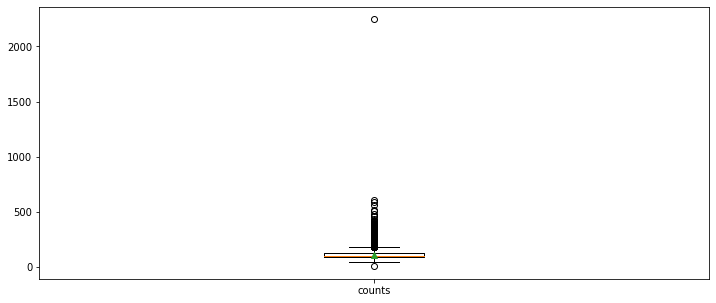

In [7]:
plt.figure(figsize=(12, 5))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를 입력
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 마크함

plt.boxplot([len_docs],
             labels=['counts'],
             showmeans=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9764a876a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9764a87da0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9764a87390>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9764a964e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9764a96ba8>],
 'means': [<matplotlib.lines.Line2D at 0x7f9764a96860>]}

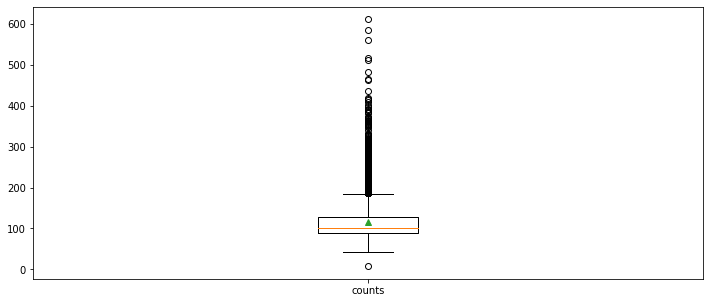

In [8]:
filtered_len_docs = [l for l in len_docs if l < 2000]

plt.figure(figsize=(12, 5))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를 입력
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 마크함

plt.boxplot(filtered_len_docs,
             labels=['counts'],
             showmeans=True)

Text(0, 0.5, 'Probability')

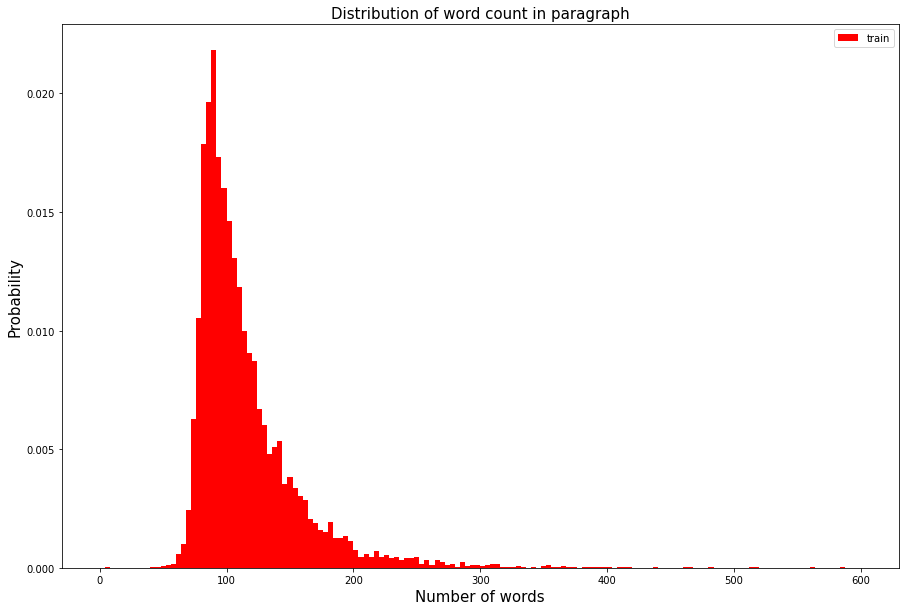

In [9]:
plt.figure(figsize=(15, 10))
plt.hist(filtered_len_docs, bins=150, range=[0,600], facecolor='r', density=True, label='train')
plt.title("Distribution of word count in paragraph", fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

### 지문 텍스트 버트 토크나이저 토큰 길이 분석

In [13]:
len_bert_tokenized_docs = []
for d in documents:
    len_bert_tokenized_docs.append(len(bert_tokenizer.encode(d, add_special_tokens=False).tokens))
    
print('텍스트 최대 길이: {}'.format(np.max(len_bert_tokenized_docs)))
print('텍스트 최소 길이: {}'.format(np.min(len_bert_tokenized_docs)))
print('텍스트 평균 길이: {:.2f}'.format(np.mean(len_bert_tokenized_docs)))
print('텍스트 길이 표준편차: {:.2f}'.format(np.std(len_bert_tokenized_docs)))
print('텍스트 중간 길이: {}'.format(np.median(len_bert_tokenized_docs)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('제 1 사분위 텍스트 길이: {}'.format(np.percentile(len_bert_tokenized_docs, 25)))
print('제 3 사분위 텍스트 길이: {}'.format(np.percentile(len_bert_tokenized_docs, 75)))

텍스트 최대 길이: 6367
텍스트 최소 길이: 120
텍스트 평균 길이: 311.88
텍스트 길이 표준편차: 129.44
텍스트 중간 길이: 279.0
제 1 사분위 텍스트 길이: 239.0
제 3 사분위 텍스트 길이: 344.0


{'whiskers': [<matplotlib.lines.Line2D at 0x7f97648046a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9764804da0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9764804390>],
 'medians': [<matplotlib.lines.Line2D at 0x7f976480e4e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f976480eba8>],
 'means': [<matplotlib.lines.Line2D at 0x7f976480e860>]}

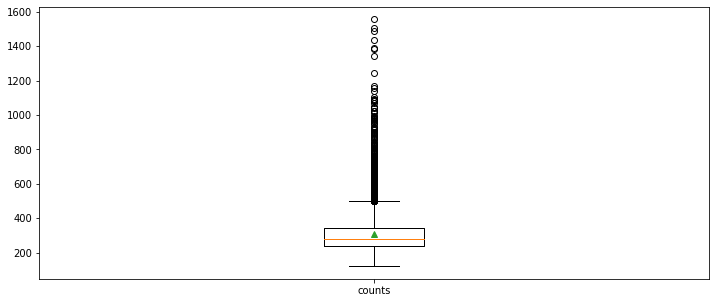

In [14]:
filtered_len_bert_tokenized_docs = [l for l in len_bert_tokenized_docs if l < 3000]

plt.figure(figsize=(12, 5))

plt.boxplot(filtered_len_bert_tokenized_docs,
             labels=['counts'],
             showmeans=True)

Text(0, 0.5, 'Probability')

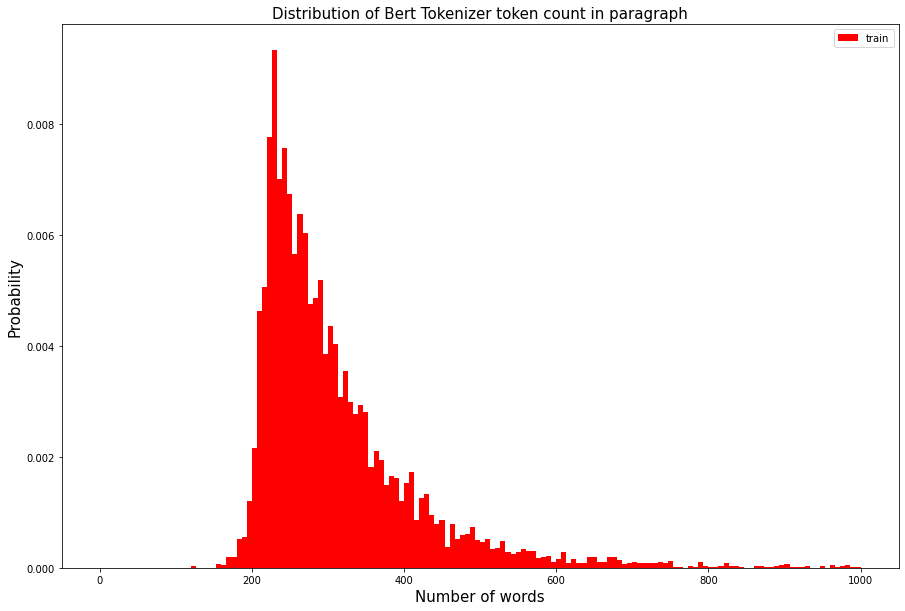

In [15]:
plt.figure(figsize=(15, 10))
plt.hist(filtered_len_bert_tokenized_docs, bins=150, range=[0,1000], facecolor='r', density=True, label='train')
plt.title("Distribution of Bert Tokenizer token count in paragraph", fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

## 지문 텍스트 어휘 빈도 분석

### 어절 토큰 기준

In [16]:
sentences = []
for d in documents:
    sentences += sent_tokenize(d)

print('전체 문장 수: {}'.format(len(sentences)))
sampled_docs = sample(sentences, 20000)

전체 문장 수: 67892


(-0.5, 799.5, 599.5, -0.5)

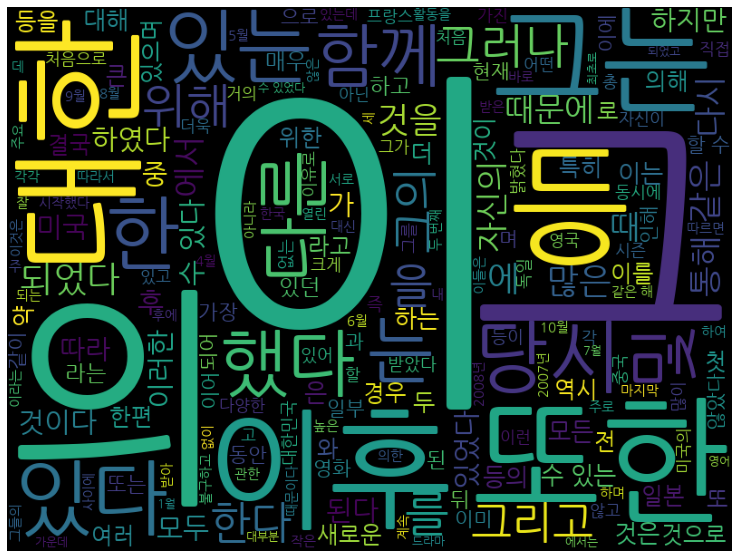

In [17]:
font_path = os.path.join(DATA_IN_PATH, 'NanumGothic.ttf')
cloud = WordCloud(font_path = font_path, width=800, height=600).generate(' '.join(sampled_docs))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

### 명사 토큰 기준

(-0.5, 799.5, 599.5, -0.5)

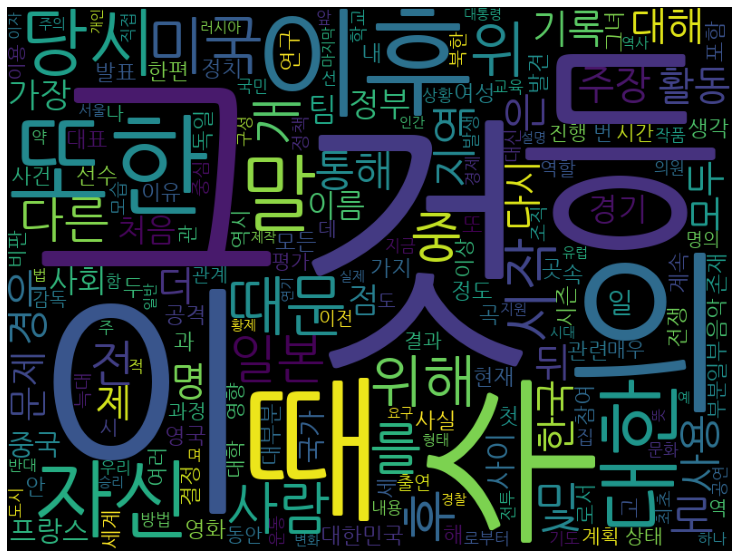

In [18]:
noun_extracted_docs = []
for d in sampled_docs:
    noun_extracted_docs += phoneme_tokenizer.nouns(d)

cloud = WordCloud(font_path = font_path, width=800, height=600).generate(' '.join(noun_extracted_docs))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

## 질문 데이터 분석

In [19]:
questions = []
for d in train_data['data']:
    qas = [p['qas'] for p in d['paragraphs']]
    for c in qas:
        questions += [q['question'] for q in c]
    
print('전체 질문 수: {}'.format(len(questions)))

전체 질문 수: 60407


### 질문 텍스트 어절 토큰 길이 분석

In [20]:
len_qs = []
for q in questions:
    len_qs.append(len(q.split()))
    
print('텍스트 최대 길이: {}'.format(np.max(len_qs)))
print('텍스트 최소 길이: {}'.format(np.min(len_qs)))
print('텍스트 평균 길이: {:.2f}'.format(np.mean(len_qs)))
print('텍스트 길이 표준편차: {:.2f}'.format(np.std(len_qs)))
print('텍스트 중간 길이: {}'.format(np.median(len_qs)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('제 1 사분위 텍스트 길이: {}'.format(np.percentile(len_qs, 25)))
print('제 3 사분위 텍스트 길이: {}'.format(np.percentile(len_qs, 75)))

텍스트 최대 길이: 35
텍스트 최소 길이: 1
텍스트 평균 길이: 7.85
텍스트 길이 표준편차: 3.09
텍스트 중간 길이: 7.0
제 1 사분위 텍스트 길이: 6.0
제 3 사분위 텍스트 길이: 10.0


{'whiskers': [<matplotlib.lines.Line2D at 0x7f97645e3828>,
 'caps': [<matplotlib.lines.Line2D at 0x7f97645e3080>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f97645e3cf8>],
 'medians': [<matplotlib.lines.Line2D at 0x7f976467bd68>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f97646fca20>],
 'means': [<matplotlib.lines.Line2D at 0x7f97647b0978>]}

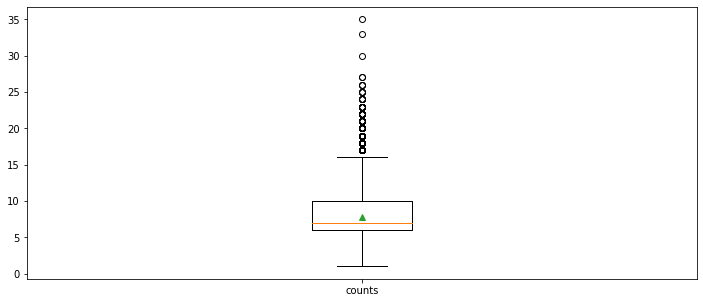

In [21]:
plt.figure(figsize=(12, 5))

plt.boxplot([len_qs],
             labels=['counts'],
             showmeans=True)

Text(0, 0.5, 'Probability')

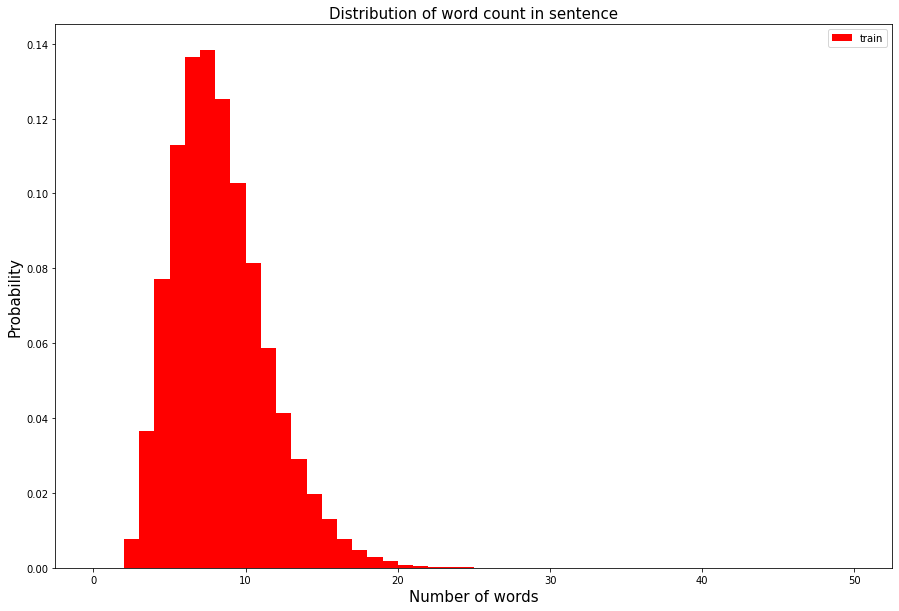

In [22]:
plt.figure(figsize=(15, 10))
plt.hist(len_qs, bins=50, range=[0,50], facecolor='r', density=True, label='train')
plt.title("Distribution of word count in sentence", fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

### 질문 텍스트 버트 토크나이저 토큰 길이 분석

In [23]:
len_bert_tokenized_q = []
for q in questions:
    len_bert_tokenized_q.append(len(bert_tokenizer.encode(q, add_special_tokens=False).tokens))
    
print('텍스트 최대 길이: {}'.format(np.max(len_bert_tokenized_q)))
print('텍스트 최소 길이: {}'.format(np.min(len_bert_tokenized_q)))
print('텍스트 평균 길이: {:.2f}'.format(np.mean(len_bert_tokenized_q)))
print('텍스트 길이 표준편차: {:.2f}'.format(np.std(len_bert_tokenized_q)))
print('텍스트 중간 길이: {}'.format(np.median(len_bert_tokenized_q)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('제 1 사분위 텍스트 길이: {}'.format(np.percentile(len_bert_tokenized_q, 25)))
print('제 3 사분위 텍스트 길이: {}'.format(np.percentile(len_bert_tokenized_q, 75)))

텍스트 최대 길이: 91
텍스트 최소 길이: 4
텍스트 평균 길이: 22.07
텍스트 길이 표준편차: 7.96
텍스트 중간 길이: 21.0
제 1 사분위 텍스트 길이: 16.0
제 3 사분위 텍스트 길이: 27.0


{'whiskers': [<matplotlib.lines.Line2D at 0x7f975ba7b2e8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f975ba7b9e8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f975ba6ff98>],
 'medians': [<matplotlib.lines.Line2D at 0x7f975ba04128>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f975ba047f0>],
 'means': [<matplotlib.lines.Line2D at 0x7f975ba044a8>]}

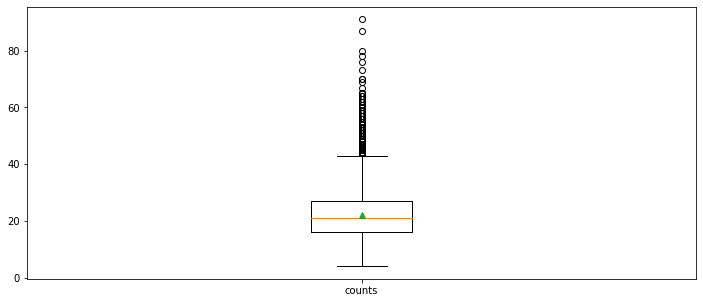

In [24]:
plt.figure(figsize=(12, 5))

plt.boxplot([len_bert_tokenized_q],
             labels=['counts'],
             showmeans=True)

Text(0, 0.5, 'Probability')

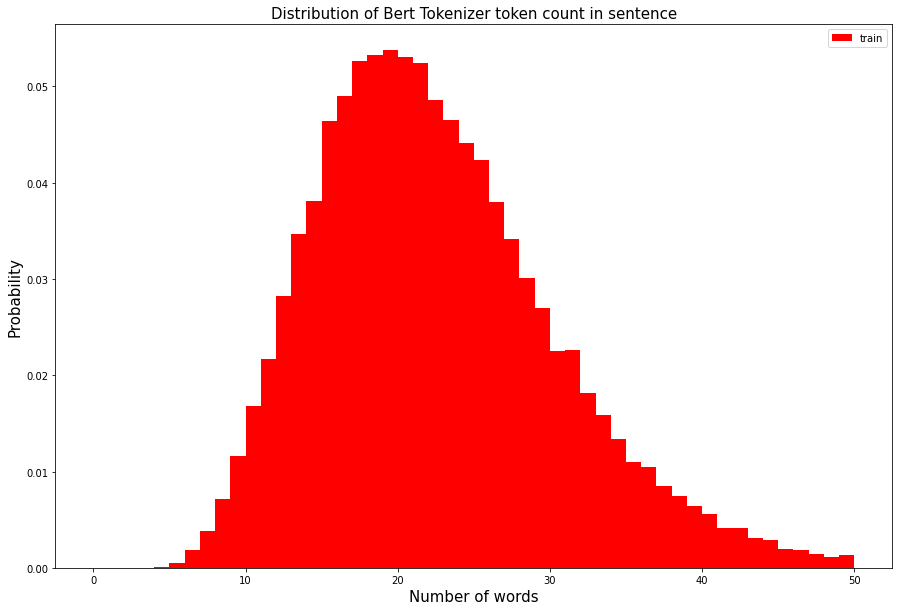

In [25]:
plt.figure(figsize=(15, 10))
plt.hist(len_bert_tokenized_q, bins=50, range=[0,50], facecolor='r', density=True, label='train')
plt.title("Distribution of Bert Tokenizer token count in sentence", fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

## 질문 텍스트 어휘 빈도 분석

### 어절 토큰 기준

In [26]:
sampled_questions = sample(questions, 20000)

(-0.5, 799.5, 599.5, -0.5)

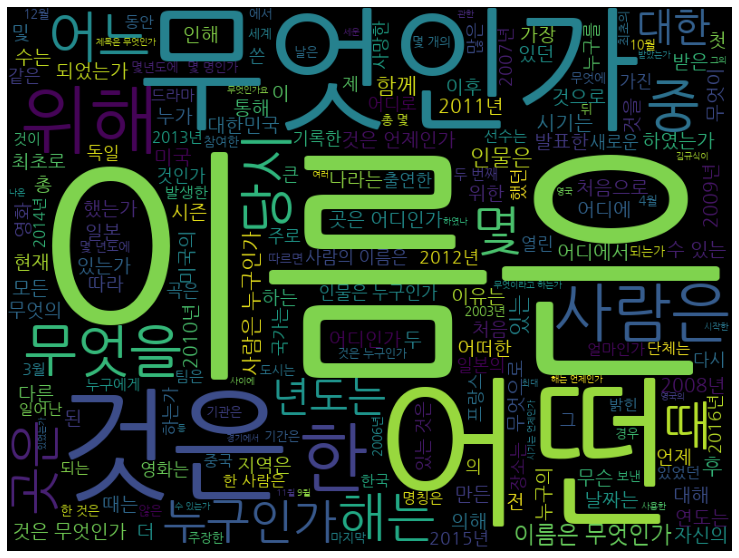

In [27]:
cloud = WordCloud(font_path = font_path, width=800, height=600).generate(' '.join(sampled_questions))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

### 명사 토큰 기준

(-0.5, 799.5, 599.5, -0.5)

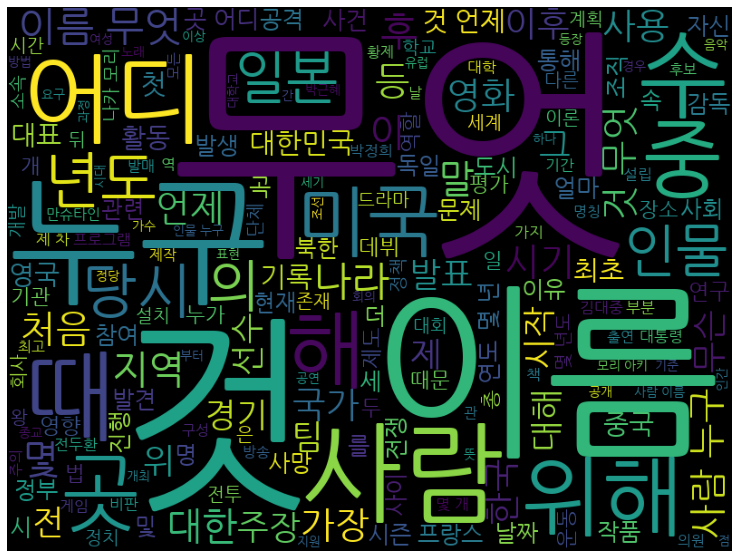

In [28]:
noun_extracted_qs = []
for q in sampled_questions:
    noun_extracted_qs += phoneme_tokenizer.nouns(q)

cloud = WordCloud(font_path = font_path, width=800, height=600).generate(' '.join(noun_extracted_qs))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')